In [1]:
# Fashion MNIST Dataset
# https://www.kaggle.com/datasets/zalando-research/fashionmnist
# consist of a training set of 60,000 examples and a test set of 10,000 examples
# each example is a 28x28 grayscale image, associated with a label from 10 classes

In [2]:
# pip install tensorflow matplotlib tensorflow-datasets ipywidgets
# pip list

### 1. Import Dependencies and Data

In [3]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# import tensorflow
import tensorflow as tf
# configure gpu
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
     tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# import tensorflow datasets
import tensorflow_datasets as tfds
# load fashion_mnist data
ds = tfds.load('fashion_mnist', split='train')
print(ds)

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


In [5]:
# import matplotlib for visualization
from matplotlib import pyplot as plt

In [6]:
# show data sample
data_sample = ds.as_numpy_iterator().next()
data_sample
print(data_sample['image'].shape)
print(data_sample['label'])

(28, 28, 1)
2


### 2. Visualize Data and Build Dataset

In [7]:
# import numpy for data transformation
import numpy as np

In [ ]:
# setup iterator
data_iterator = ds.as_numpy_iterator()
# get data out of pipeline
data_iterator.next()['image']

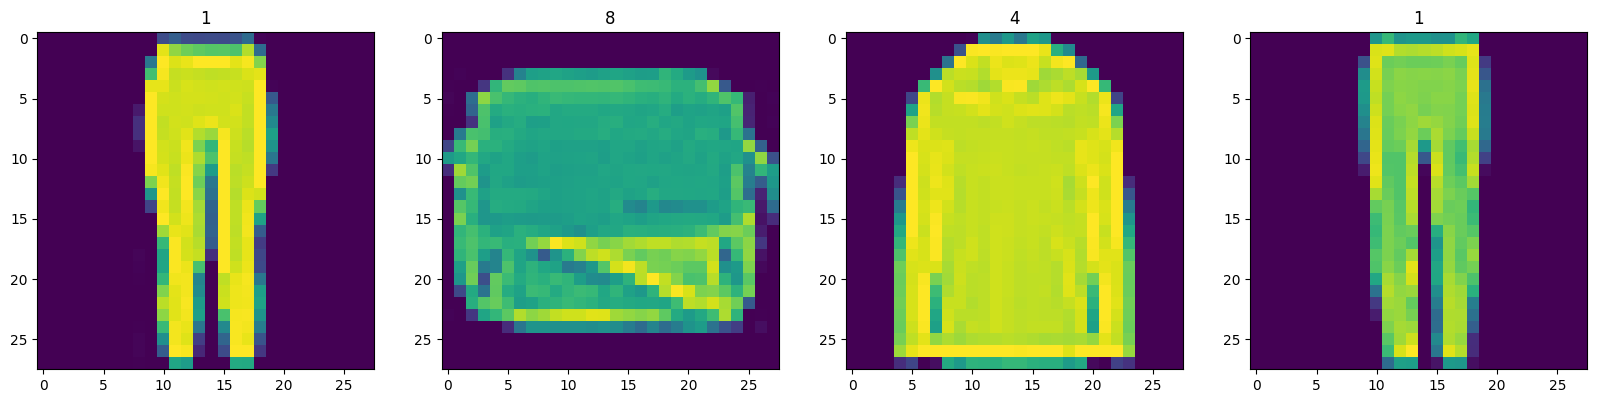

In [9]:
# visualize image samples
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for image_index in range(4):
    # get one image and label
    img_sample = data_iterator.next()
    # plot the image
    ax[image_index].imshow(np.squeeze(img_sample['image']))
    # give the label as title
    ax[image_index].title.set_text(img_sample['label'])    

In [10]:
# scale the image from [0, 255] to [0, 1]
def scale_images(data):
    image = data['image']
    return image / 255

In [11]:
# reload dataset
ds = tfds.load('fashion_mnist', split='train' )
# call scale_images()
ds = ds.map(scale_images)
# cache dataset into memory to speed up pipeline 
ds = ds.cache()
# shuffle the dataset
ds = ds.shuffle(60000)
# batch the dataset into 128 images per batch
ds = ds.batch(128)
# prefetch: overlap preprocessing and model execution of a training step
ds = ds.prefetch(tf.data.AUTOTUNE)

In [12]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

### 3. Build GAN Neural Network

#### 3.1 Import Model Components

In [13]:
# import Sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# import layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

#### 3.2 Build Generator

In [14]:
def build_generator():
    model = Sequential()

    # input block: input random noise (number_of_images, 128, 1)
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    # reshape to (7,7,128)
    model.add(Reshape((7,7,128)))

    # upsampling block 1
    model.add(UpSampling2D()) # (14,14,128)
    model.add(Conv2D(128, 5, padding='same')) # (14,14,128)
    model.add(LeakyReLU(0.2)) # (14,14,128)

    # upsampling block 2
    model.add(UpSampling2D()) # (28,28,128)
    model.add(Conv2D(128, 5, padding='same')) # (28,28,128)
    model.add(LeakyReLU(0.2)) # (28,28,128)

    # convolutional block 1
    model.add(Conv2D(128, 4, padding='same')) # (28,28,128)
    model.add(LeakyReLU(0.2)) # (28,28,128)

    # convolutional block 2
    model.add(Conv2D(128, 4, padding='same')) # (28,28,128)
    model.add(LeakyReLU(0.2)) # (28,28,128)

    # final convolutional layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid')) # (28,28,1)

    return model

In [15]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

1/1 [==============================] - 6s 6s/step


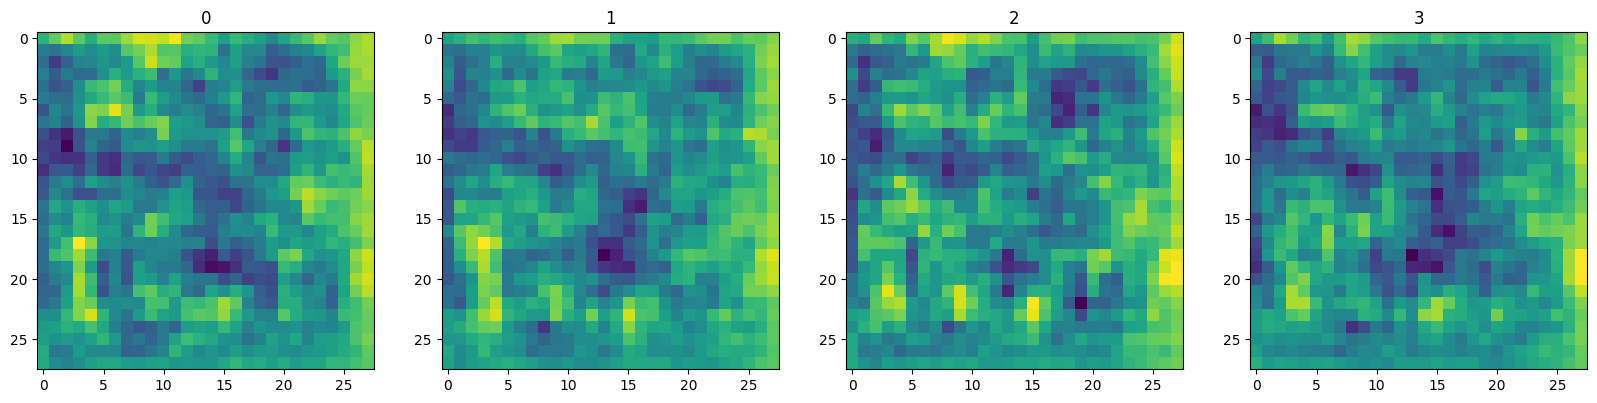

In [16]:
# first test of generator
input_noise = np.random.rand(4,128,1)
generated_images = generator.predict(input_noise)

# visualize generated images
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for img_index, img in enumerate(generated_images):
    ax[img_index].imshow(np.squeeze(img))
    ax[img_index].title.set_text(img_index)

#### 3.3 Build Discriminator

In [17]:
def build_discriminator():
    model = Sequential()

    # convolutional block 1
    model.add(Conv2D(32, 5, input_shape=(28,28,1))) # (24,24,32)
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # convolutional block 2
    model.add(Conv2D(64, 5)) # (20,20,64)
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # convolutional block 3
    model.add(Conv2D(128, 5)) # (16,16,128)
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # convolutional block 4
    model.add(Conv2D(256, 5)) # (12,12,256)
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # flatten layer
    model.add(Flatten()) # 12*12*256
    model.add(Dropout(0.4))

    # final dense layer to get to one output -> binary classification
    model.add(Dense(1, activation='sigmoid'))

    return model
    

In [18]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [19]:
# first test of discriminator
print(generated_images.shape)
discriminator.predict(generated_images)

(4, 28, 28, 1)
1/1 [==============================] - 0s 485ms/step


array([[0.4834343 ],
       [0.48334572],
       [0.48330373],
       [0.4834002 ]], dtype=float32)

### 4. Construct Training Loop

#### 4.1 Setup Losses and Optimizers

In [20]:
# import Adam as the optimizer for both generator and discriminator
from tensorflow.keras.optimizers import Adam
# import binary cross entropy as the loss for both generator and discriminator
from tensorflow.keras.losses import BinaryCrossentropy

In [21]:
generator_optim = Adam(learning_rate=0.0001)
discriminator_optim = Adam(learning_rate=0.00001)
generator_loss = BinaryCrossentropy()
discriminator_loss = BinaryCrossentropy()

#### 4.2 Build Subclassed Model

In [22]:
# import base model class
from tensorflow.keras.models import Model

In [23]:
# build subclassed model to override train_step()
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.generator = generator
        self.discriminator = discriminator
    
    def compile(self, generator_optim, discriminator_optim, generator_loss, discriminator_loss, *args, **kwargs):
        super().compile(*args, **kwargs)

        self.generator_optim = generator_optim
        self.discriminator_optim = discriminator_optim
        self.generator_loss = generator_loss
        self.discriminator_loss = discriminator_loss    

    # override the training step function of the Model class to customize training algorithm
    # train_step(self, data) will be called by fit() for every batch of data
    def train_step(self, batch):

        # get real data
        real_images = batch
        # generate fake data, input random noise (number_of_images, 128, 1)
        fake_images = self.generator(tf.random.normal((128,128,1)), training=False)

        # train discriminator
        # GradientTape() is used to record operations for automatic differentiation
        with tf.GradientTape() as discriminator_tape:
            # pass real and fake images to the discriminator
            pred_real = self.discriminator(real_images, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            predictions = tf.concat([pred_real, pred_fake], axis=0)

            # create labels for real and fake images
            # 0: real images, 1: fake images
            D_labels = tf.concat([tf.zeros_like(pred_real), tf.ones_like(pred_fake)], axis=0)

            # add noise to the labels (true outputs)
            # adding noise to labels can help to prevent overfitting
            # also make network less able to memorize training samples because they are changing all of the time
            noise_real = 0.15 * tf.random.uniform(tf.shape(pred_real))
            noise_fake = -0.15 * tf.random.uniform(tf.shape(pred_fake))
            noise = tf.concat([noise_real, noise_fake], axis=0)
            
            D_labels += noise

            # calculate loss using binary cross entropy
            total_discriminator_loss = self.discriminator_loss(D_labels, predictions)

        # apply backpropagation and optimizer
        discriminator_grad = discriminator_tape.gradient(total_discriminator_loss, self.discriminator.trainable_variables)
        self.discriminator_optim.apply_gradients(zip(discriminator_grad, self.discriminator.trainable_variables))

        # train generator
        with tf.GradientTape() as generator_tape:
            # generate fake images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)

            # get predicted labels from discriminator
            predicted_labels = self.discriminator(gen_images, training=False)

            # create labels for generated fake images
            # the target is to fake out the discriminator -> 0: real images
            G_labels = tf.zeros_like(predicted_labels)

            # calculate loss using binary cross entropy
            total_generator_loss = self.generator_loss(G_labels, predicted_labels)

        # apply backpropagation and optimizer
        generator_grad = generator_tape.gradient(total_generator_loss, self.generator.trainable_variables)
        self.generator_optim.apply_gradients(zip(generator_grad, self.generator.trainable_variables))

        return {"discriminator_loss": total_discriminator_loss, "generator_loss": total_generator_loss}

In [24]:
# create instance of subclassed model
fashion_gan = FashionGAN(generator, discriminator)

In [25]:
# compile model
fashion_gan.compile(generator_optim, discriminator_optim, generator_loss, discriminator_loss)

#### 4.3 Build Callback

In [26]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [27]:
class ModelMonitor(Callback):
    def __init__(self, num_img=1, random_input_dim=128):
        self.num_img = num_img
        self.random_input_dim = random_input_dim

    # override subclasses, which is called at the end of each epoch
    def on_epoch_end(self, epoch, logs=None):
        random_input_vectors = tf.random.uniform((self.num_img, self.random_input_dim, 1))
        generated_images = self.model.generator(random_input_vectors)
        generated_images *= 255
        generated_images.numpy() # from tensor to numpy array
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png')) 

#### 4.4 Train Model

In [28]:
hist = fashion_gan.fit(ds, epochs=400, callbacks=[ModelMonitor()], use_multiprocessing = True) 

Epoch 1/400


2023-11-22 10:40:16.061821: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


469/469 [==============================] - 63s 118ms/step - discriminator_loss: 0.5362 - generator_loss: 0.8700
Epoch 2/400
469/469 [==============================] - 56s 118ms/step - discriminator_loss: 0.3163 - generator_loss: 2.2987
Epoch 3/400
469/469 [==============================] - 55s 118ms/step - discriminator_loss: 0.2758 - generator_loss: 2.6433
Epoch 4/400
469/469 [==============================] - 55s 118ms/step - discriminator_loss: 0.2738 - generator_loss: 2.6589
Epoch 5/400
469/469 [==============================] - 56s 118ms/step - discriminator_loss: 0.2728 - generator_loss: 2.6605
Epoch 6/400
469/469 [==============================] - 56s 119ms/step - discriminator_loss: 0.2723 - generator_loss: 2.6585
Epoch 7/400
469/469 [==============================] - 56s 119ms/step - discriminator_loss: 0.2707 - generator_loss: 2.6517
Epoch 8/400
469/469 [==============================] - 56s 119ms/step - discriminator_loss: 0.2700 - generator_loss: 2.6501
Epoch 9/400
469/469 

#### 4.5 Review Performance

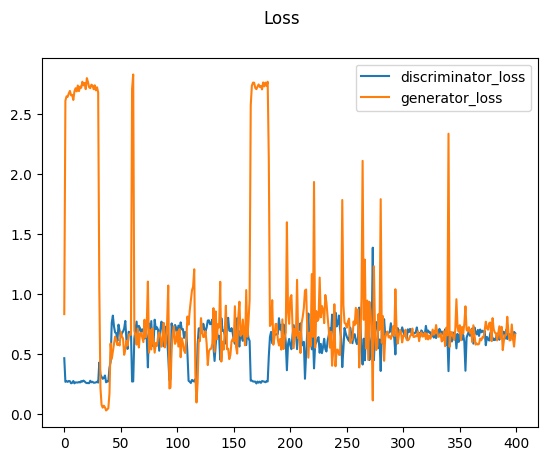

In [29]:
# plot loss
plt.suptitle('Loss')
plt.plot(hist.history['discriminator_loss'], label='discriminator_loss')
plt.plot(hist.history['generator_loss'], label='generator_loss')
plt.legend()
plt.show()

### 5. Test the Generator

#### 5.1 Save the Model

In [ ]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')

#### 5.2 Generate Images

In [31]:
generator.load_weights(os.path.join('generator.h5'))

In [41]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 [==============================] - 0s 21ms/step


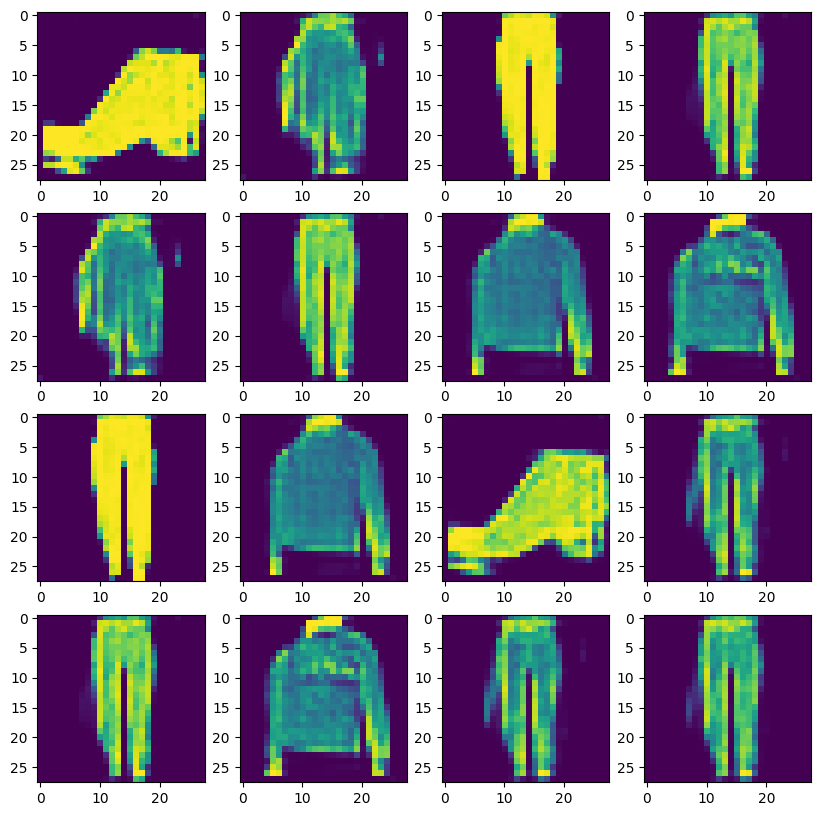

In [42]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])